# Apply AI Superresolution to video - Train New Network from Video Frames

## Use a perception loss
https://github.com/richzhang/PerceptualSimilarity

 

# Get a video dataset to do better training
- higher resolution than used in research

### super 8 look https://www.youtube.com/watch?v=7Q5UZmwxIXo
- low focus (diffusion and blur - bokah)
- low contrast
- camera is more shakey on home movies
- high depth of field everything is sharp
- 4x3
- film grain
- color changes
- mpeg2 compression noise

### VCR look
- jitter on scan lines - see http://www.avisynth.nl/users/vcmohan/DeJitter/DeJitter.htm
- chroma issues https://forum.videohelp.com/threads/397928-Imrpove-old-video-recorded-by-a-bad-camera?s=0a1230911434e7442d05b6b6cee8e6d2

- jpeg compression artifacts

## use images of related material to train superres
- family photos to train for family videos
- need water and outdoors
- use video samples for video
- use film examples for super8

## Data Augmentation
- sample a few frames from a few places - complete
- different blur levels- complete
- different blur levels in the same image - complete
- convolution with disk - complete
- left-right flip - complete
- contrast and brightness - complete
- random crop - use center crop
- crop to the super8 resolution 720x480 or video 320x240 - complete
- GAN statistics
- predict level of blur with same network to encourage differentiation to that
- input of a filter that detects light reflections to help infer blurring
- try mixup
- use a single shot classifier output as an input

- see this library for blending images https://pypi.org/project/blend-modes/


## Optimization
- Use Adam - complete
- Use optimal learning rate
- freeze layers
- dropout
- use fp16 - pytorch1.6 has a new library for this - complete
- train on low res and increase resolution - does not seem to help in convergence

## losses
- try l1 loss - does not converge
- try perceptive loss vgg18 - complete
- perceptive loss uses 256x256 images - too low res, so use overlapping subsets of image to calc loss
- combine perceptive and mse loss
- calculate mse loss on a smoothed version of output compared to input (which is smoothed) - ensure reversal matches


## do comparisons for standard test sets
- not super useful since they use gaussian blurring, bicubic interpolation
- get very focused images and use as a validation and test set - prefer one thats published


## Results & Analysis
- Fixes - jpeg artifacts were fixed at one level 30 and slope at 0.01 in:
Superresolution train vdsr with multifuz
Superresolution train vdsr with perception loss multifuz

- mse only goes so far.  too strict
- Perceptual loss helps improve it, but input is 256x256 resolution so limited sharpness.
- Perceptual loss tiled (hires) causes too much causes artifacts
- multifuz improves results especially with perceptual loss, handles different fuzziness better

Next experiment
- training may not need to go as long - complete
- set kernel range from 1 to 20 - vs 4-20 need lower range too - complete
- combination of hi res perceptual and mse on smoothed versions of input.- complete
- give more emphasis to mse

Other ideas
- train on cleaner images div8K
- cascade 2 models.  Train first as usual.  Use it to preprocess input to train second model
- apply mix-up
- better model and apply to all 3 colors - tried, but no improvement.
- try vgg perception metric
- focus prediction


RCAN Results
- Uses lots of resources as scale of image increases
- Does not handle different scales well
- not meant for restoration - 
To try
- Apply pretrained model on a patch thats 48x48 then can judge if its worth making an approach to apply repeatedly to larger images.
- train vdsr with a convolutional upscaling up front, attention, residuals.

UNET results
- Some sharpening but not drastic.  Not better than VDSR
- Used 2x GPU mem than VDSR

New Network results
- Performs as well as VDSR qualitatively, need to check.
- using Div2K gives better results (needs low learning rate)
- try with L1 norm (less noise sensitive)
- add upscale in the middle to allow more flexibility - nn.ConvTranspose2d(in_channels=C, out_channels=M, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False)
- add  with torch.no_grad():  to validation and prediction with the model to speed up computations.


To Try
- UNET or VDSR with MAXout nonlinear function.  Try different activation functions (mish,etc).
- consistency error measure like fastai superres
- provide input,target  pairs with no fuzziness in the training set.
- Train exclusively on very sharp  images (DIV2K)
- Predict focus as a segmentation in addition to enhancing
- have 3 channel inputs (RGB or ??) and then have 1 channel output
- provide frame-1,frame,frame+1 to predict frame
- opposite of bottleneck - input resolution -> high res -> input res blocks.
- combo of UNET and VDSR
- attention?
- combo of perception and mse measure
- add validation set
- sort dataset into hard cases and easy cases, making cases harder with time.  (train on easy cases first, then fine tune with harder cases)
- make the camera model version of the data loader
- use mse but give more error to perception
- try reflection padding







## Share results
- put out an example on youtube to allow comparison


# Project Documentation

In [1]:

from pathlib import Path
import os


project_base = "/media/SSD/superres/"
results_folder = "Results"
data_folder = "video_data"
model_folder = "checkpoint"

model_name_base = "NEWCNN4"


## Experiment documentation

In [2]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [3]:
print("NOTEBOOK_FULL_PATH:\n", NOTEBOOK_FULL_PATH)

NOTEBOOK_FULL_PATH:
 /SSD_link/superres/Superresolution train New Network upscale PRelu L1 Div2 camspec training.ipynb


In [4]:
nb_path = Path(NOTEBOOK_FULL_PATH)
print(nb_path)

# Make result folder if it does not exist
result_path = Path(project_base, results_folder , nb_path.stem )
print(result_path)
os.makedirs(result_path, exist_ok=True)

/SSD_link/superres/Superresolution train New Network upscale PRelu L1 Div2 camspec training.ipynb
/media/SSD/superres/Results/Superresolution train New Network upscale PRelu L1 Div2 camspec training


In [5]:
model_out_path=Path(project_base)/model_folder
print(model_out_path)
os.makedirs(model_out_path, exist_ok=True)

/media/SSD/superres/checkpoint


In [6]:
# Tie a result to a set of params.  Tie a set of params to a model.  Tie a model to a notebook.
# register the experiment to get a unique run id
# save all the results in a repository
# use github to do it?

In [7]:

#%reload_ext autoreload
#%autoreload 2
#%matplotlib inline


import cv2 
import numpy as np
import subprocess as sp
import time
from tqdm import tqdm, trange
import torch
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from torchvision.transforms import RandomHorizontalFlip,ColorJitter
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize, Grayscale,ToPILImage

import random

import lpips #https://github.com/richzhang/PerceptualSimilarity

In [8]:
import torch.utils.data as data

from os import listdir
from os.path import join
from PIL import Image, ImageFilter
import numpy as np
import torchvision as vision

import numbers

torch.cuda.manual_seed(42)

Create a data loader
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data.py
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data_utils.py

In [9]:
import fnmatch

In [10]:
from superres_utils import make_framelist, load_frame, RescaleCrop, Multifuz, DatasetFromVideoFolder
from superres_utils import show_batch
from superres_utils import pil_disk_blur, display_PSNR, test_results, superres_mp4

In [11]:
# get a list of all the data
instances = make_framelist("/home/filip/SSD_link/superres/DIV2K/DIV2K_train_HR",1)

(731, 491) (720, 480)


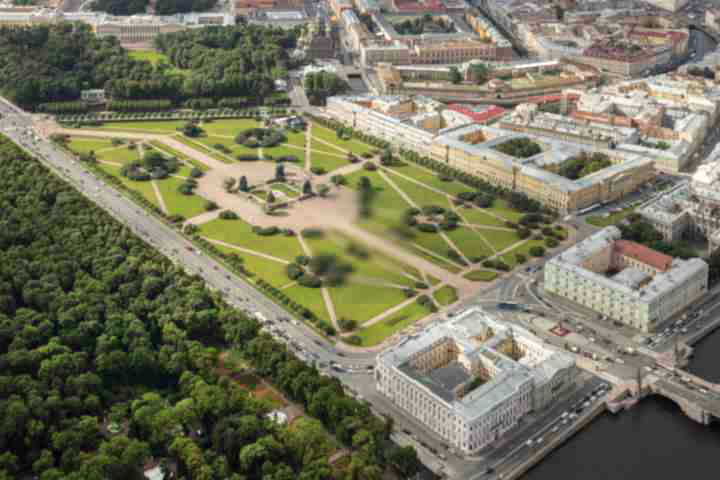

In [12]:
#test the Multifuz transform
im=load_frame(instances[10])
#im = Grayscale(num_output_channels=1)(im)
im = RescaleCrop(crop_size=(480,720),kernel_width=10)(im)
im_res = Multifuz(crop_size = (480,720),
                  center=(360,240),
                  kernel_a=2, 
                  kernel_b=10,
                  quality=np.int16(22), 
                  slope=.1,
                 radius=50,
                 scale=1)(im)
print(im.size,im_res.size)
type(im_res)
im_res

In [13]:
def input_transform():        
    return Compose([        
        Grayscale(num_output_channels=1),
        ToTensor(),
    ])



def target_transform(crop_size):
    return Compose([
        Grayscale(num_output_channels=1),
        CenterCrop(crop_size),
        ToTensor(),
    ])


In [14]:
train_dir = "/home/filip/SSD_link/superres/DIV2K/DIV2K_train_HR"
#train_dir = "/home/filip/SSD_link/superres/video_data/train_data"
frame_sample_size =10
batch_size = 4 # Make 4 For FP16, 480x720 size images
crop_size = (480,720)
#crop_size = (256,256)
kernel_range=(1,16)
quality_range=(30,90) 
slope_range=(0.001, 0.1)
radius_range=(0,0)  # make all one fuzziness
scale_range=(1/2,2)
Flip_hor=True
Rand_bright_contrast=True

In [15]:
train_set = DatasetFromVideoFolder(train_dir,crop_size,frame_sample_size,
                                   input_transform=input_transform(),
                                   target_transform=target_transform(crop_size),
                                   Flip_hor=Flip_hor,
                                   Rand_bright_contrast=Rand_bright_contrast,
                                   kernel_range=kernel_range,
                                   quality_range=quality_range,
                                   slope_range=slope_range,
                                   radius_range=radius_range,
                                   scale_range=scale_range,
                                   max_kernel=10
                            )
training_data_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=batch_size, shuffle=True)

In [16]:
valid_dir = "/home/filip/SSD_link/superres/DIV2K/DIV2K_valid_HR"
#frame_sample_size =10
#batch_size = 4 # Make 4 For FP16, 480x720 size images
#crop_size = (480,720)

kernel_range=(1,16)
quality_range=(30,99) 
slope_range=(0.001, 0.1)
radius_range=(0,0)  # make all one fuzziness
scale_range=(1/2,2)
Flip_hor=False
Rand_bright_contrast=False
match_exp = "*.*"

In [17]:
valid_set = DatasetFromVideoFolder(valid_dir,crop_size,frame_sample_size,
                                   input_transform=input_transform(),
                                   target_transform=target_transform(crop_size),
                                   Flip_hor=Flip_hor,
                                   Rand_bright_contrast=Rand_bright_contrast,
                                   kernel_range=kernel_range,
                                   quality_range=quality_range,
                                   slope_range=slope_range,
                                   radius_range=radius_range,
                                   scale_range=scale_range,
                                   max_kernel=10,
                                   match_exp=match_exp,
                            )
valid_data_loader = DataLoader(dataset=valid_set, num_workers=0, batch_size=batch_size, shuffle=False)

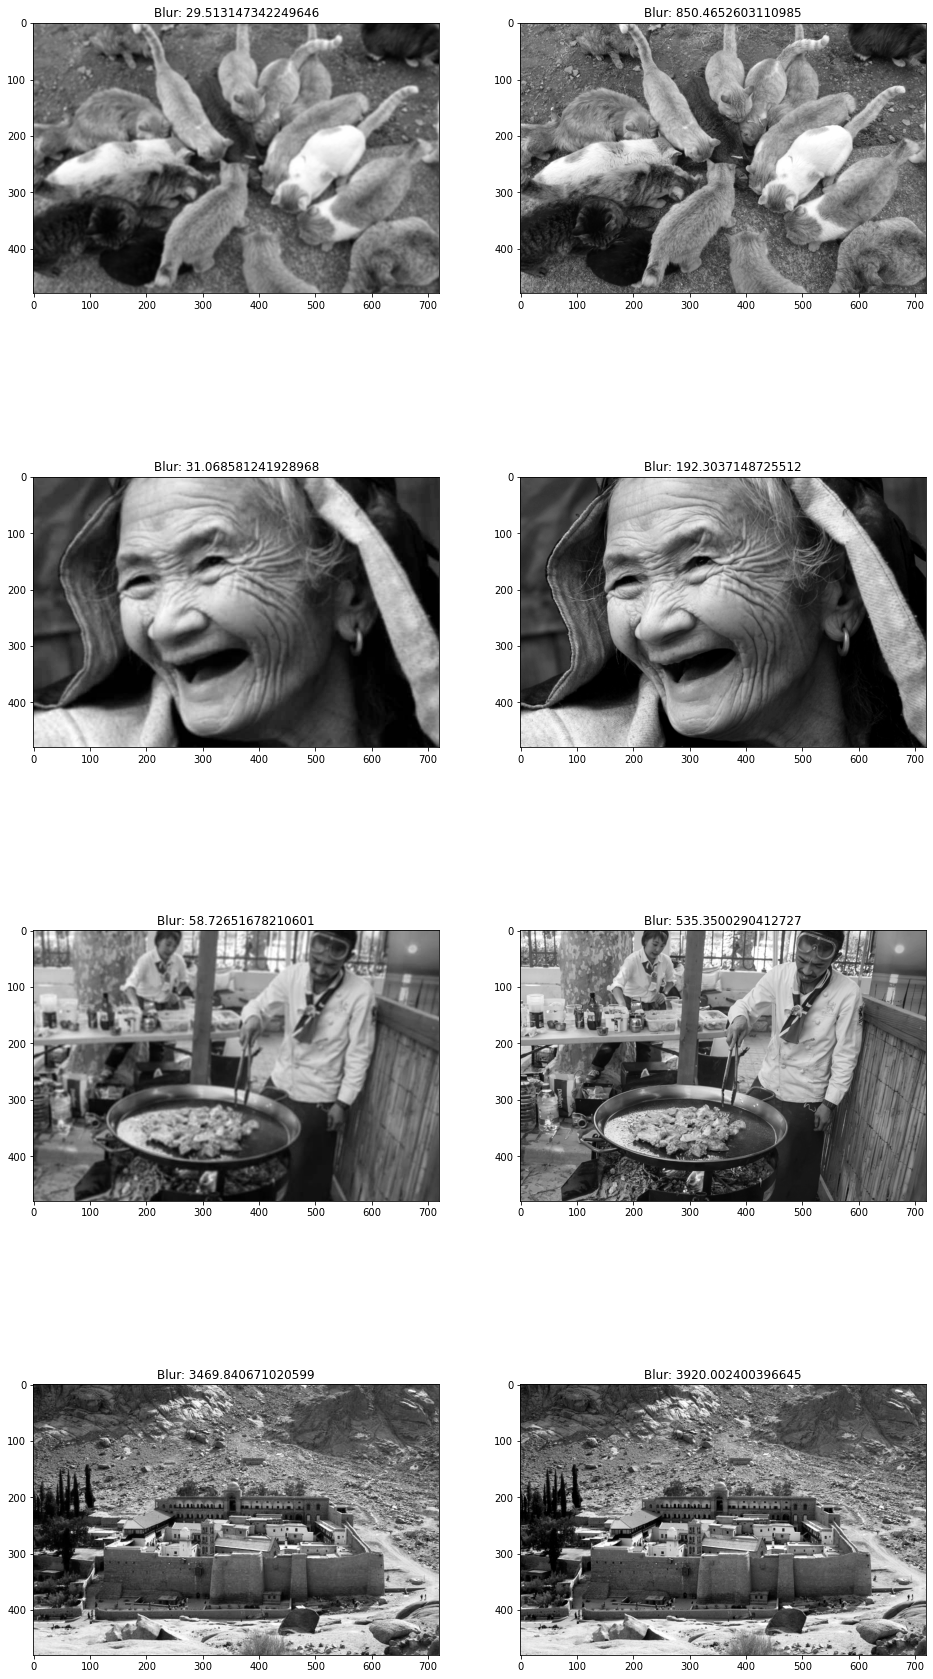

In [18]:
show_batch(training_data_loader,size =8)

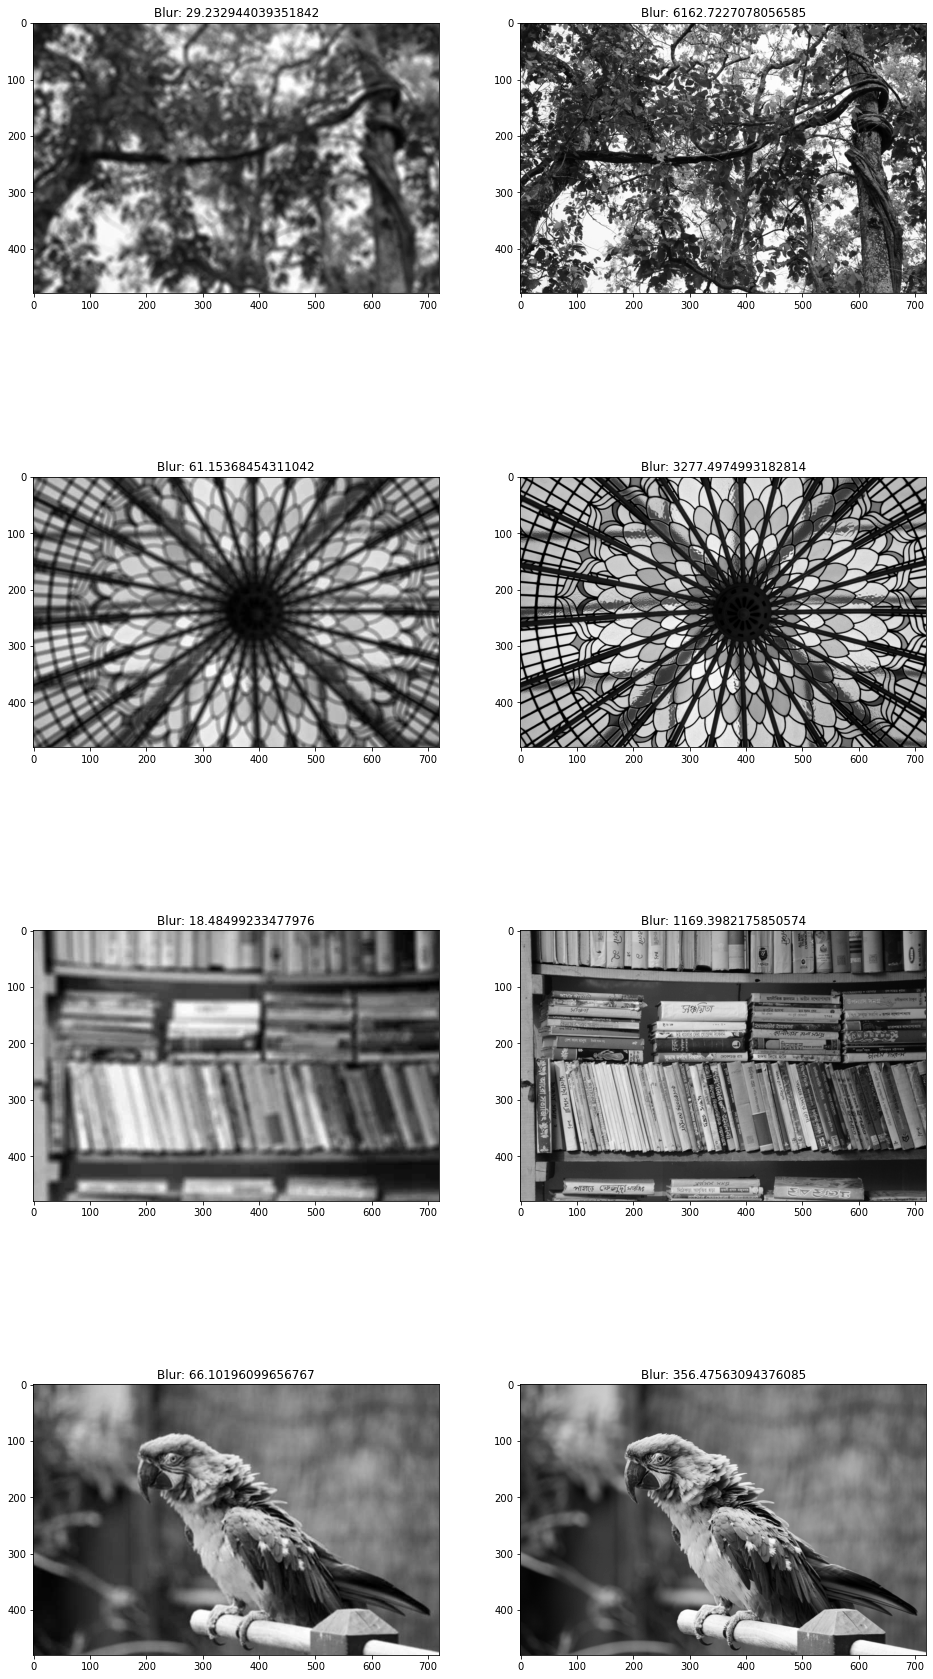

In [19]:
show_batch(valid_data_loader,size =8)

# NEW CNN

In [20]:
import torch.nn as nn

class NEWNet3(nn.Module):
    def __init__(self, c1, c2, c3):
        super(NEWNet3, self).__init__()   
        
        self.p1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=c1, kernel_size=3, stride=1, padding=1, bias=False),
            nn.PReLU(),
            nn.Conv2d(in_channels=c1, out_channels=c1, kernel_size=3, stride=1, padding=1, bias=True),
            nn.PReLU(),
            nn.Conv2d(in_channels=c1, out_channels=c1, kernel_size=3, stride=1, padding=1, bias=True),
            nn.PReLU()
        )
        
        self.p2 = nn.Sequential(
            nn.Conv2d(in_channels=c1, out_channels=c2, kernel_size=1, stride=1, padding=0, bias=True),
            nn.PReLU(),
            nn.Conv2d(in_channels=c2, out_channels=c2, kernel_size=3, stride=1, padding=1, bias=True),
            nn.PReLU(),
            nn.Conv2d(in_channels=c2, out_channels=c1, kernel_size=1, stride=1, padding=0, bias=True)
        )
        
        

        
        self.prelu = nn.PReLU()
        self.convf = nn.Conv2d(in_channels=c1, out_channels=1, kernel_size=3, stride=1, padding=1, bias=True)
        
        self.features = nn.Sequential(
            
            nn.Conv2d(c1, c1, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(c1, c1, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.regression = nn.Sequential(
            nn.Dropout(),
            nn.Linear(c1 * 6 * 6, c3),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(c3, c3),
            nn.ReLU(inplace=True),
            nn.Linear(c3, 1),
        )

              
        
        
    def forward(self, x):    
        residual = x
        x = self.p1(x)
        skip1 = x
        
        k = self.features(x)
        k = self.avgpool(k)
        k = torch.flatten(k, 1)
        k = self.regression(k)
        
        
        x = self.p2(x)
        x = x.add_(skip1)
        x = self.prelu(x)
        x = self.convf(x)
        out = torch.add(x,residual)
        return out, k

# build the model

In [21]:
#model = NEWNet2(c1=64,c2=128)
model = NEWNet3(c1=64,c2=64, c3=1024)
model.cuda()

NEWNet3(
  (p1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): PReLU(num_parameters=1)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): PReLU(num_parameters=1)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): PReLU(num_parameters=1)
  )
  (p2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): PReLU(num_parameters=1)
    (4): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (prelu): PReLU(num_parameters=1)
  (convf): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (features): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4

In [ ]:
num_pixels = crop_size[0] * crop_size[1]

In [ ]:
def loss_scaler(im):
    # scale to -1,1 and convert to 3 channel (greyscale to RBG)
    return (im * 2 - 1).expand(-1, 3, -1, -1)

In [ ]:
class Pixel_Loss(torch.nn.Module):
    
    def __init__(self,num_pixels):
        super(Pixel_Loss,self).__init__()
        self.lossfn = nn.MSELoss(reduction = 'mean')
        
        self.percep_loss_fn = lpips.LPIPS(net='alex').cuda()


        self.num_pixels = num_pixels
    #def forward(self,x,y):
        
     #   return self.num_pixels*(self.lossfn.forward(x,y))
    
    
    def forward(self,x,y):
        
        totloss = torch.mean(self.percep_loss_fn.forward(loss_scaler(x),loss_scaler(y)))
        #print("perceptual:",totloss)
        
        totloss.add_(50 * self.lossfn.forward(x,y))
        #print("total:",totloss)
        
        return totloss


In [22]:
#criterion = Pixel_Loss(num_pixels)
criterion1 = nn.L1Loss(reduction = 'mean')
criterion2 = nn.MSELoss(reduction = 'mean')

In [23]:
init_lr = .001
lr_step = 6
gradient_clip = 0.4
epochs = 54
max_kernel_scale = 17
loops = 8

In [24]:

#optimizer = optim.Adam(model.parameters(), lr=init_lr, weight_decay=1e-4)
optimizer = optim.Adam(model.parameters(), lr=init_lr, weight_decay=0)



In [25]:
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 
                                          max_lr=0.01,
                                          steps_per_epoch=len(training_data_loader),
                                          epochs=epochs)

In [26]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10**0.5 every 3 epochs"""
    lr = init_lr * (0.1 ** (.5*(epoch // lr_step)))
    return lr

In [27]:
def save_checkpoint(experiment, model, epoch, valid_error):

    model_out_str = str(model_out_path/(model_name_base+"_epoch_{}.pth")).format(epoch)
    
    state = {"experiment": experiment, "epoch": epoch ,"model": model, "valid_error": valid_error}

    torch.save(state, model_out_str)

    print("Checkpoint saved to {}".format(model_out_str))

In [28]:
import datetime
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler
#import kornia


In [29]:
from torch.optim.swa_utils import AveragedModel
swa_model = torch.optim.swa_utils.AveragedModel(model)

In [30]:
def trainfp16(training_data_loader, optimizer, scheduler, model,  epoch,scaler, loops):
    dt = str(datetime.datetime.now())
    print("Start Time:", dt)
    
    lr = adjust_learning_rate(optimizer, epoch-1)

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

    print("Epoch = {}, lr = {}".format(epoch, optimizer.param_groups[0]["lr"]))

    model.train()
    cum_loss2=0
    cum_loss1 = 0
    ct=0  ##need to use a different variable.
    ct2=0

    pbar = tqdm(total=loops*len(training_data_loader))
    for ct in range(loops):  ##need to use a different variable.
        for iteration, batch in enumerate(training_data_loader, 1):
            input, target, camera_specs = batch[0], batch[1], batch[2]


            input = input.cuda()

            target = target.cuda()
            
            k_target = (camera_specs["kernel_a"].float()/max_kernel_scale).cuda()

            optimizer.zero_grad()

            # Runs the forward pass with autocasting.
            with autocast():
                output, k = model(input)
                loss1 = criterion1(output, target)
                loss2 = criterion2(k[:,0],k_target )
                loss = loss1 + loss2


            
            scaler.scale(loss).backward()
            #loss.backward() 

            # Unscales the gradients of optimizer's assigned params in-place
            #scaler.unscale_(optimizer)

            #nn.utils.clip_grad_norm_(model.parameters(),gradient_clip) 

            #optimizer.step()
            scaler.step(optimizer)

            if epoch>1:
                swa_model.update_parameters(model)

            # Updates the scale for next iteration.
            scaler.update()

            #scheduler.step()

            cum_loss1 = cum_loss1 + loss1.data
            cum_loss2 = cum_loss2 + loss2.data

            ct = ct +1 ## Used to be batch_size



            pbar.update(1)
    pbar.close()    
   
    print("Epoch Loss:", cum_loss1/ct, " kernel est loss:", cum_loss2/ct)        

In [31]:
def validatefp16(valid_data_loader, model,  loop=10):

    model.eval()
    cum_loss2=0
    cum_loss1 = 0
    ct=0 
    
    with torch.no_grad():
        for r in trange(loop):
            for iteration, batch in enumerate(valid_data_loader, 1):
                input, target, camera_specs = batch[0], batch[1], batch[2]


                input = input.cuda()

                target = target.cuda()
                k_target = (camera_specs["kernel_a"].float()/max_kernel_scale).cuda()
                
                # Runs the forward pass with autocasting.
                with autocast():
                    output, k = model(input)
                    loss1 = criterion1(output, target)
                    loss2 = criterion2(k[:,0],k_target)

               
                cum_loss1 = cum_loss1 + loss1.data
                cum_loss2 = cum_loss2 + loss2.data

                ct = ct + 1 ## Used to be batch_size





        print("===> Epoch Validation Loss: {:.10f} , kernel pred {:.10f}".format(cum_loss1/ct,cum_loss2/ct) )
    
    return (cum_loss1/ct).item()

In [32]:
#model = torch.load("/media/SSD/superres/checkpoint/NEWCNN3_epoch_54.pth")["model"]

In [33]:
#validatefp16(valid_data_loader, model, criterion, loop=1)

f1 = "/media/SSD/superres/checkpoint/NEWCNN_epoch_"
f3 = ".pth"
lst =[]
for i in range(1,13):
    model = torch.load(f1+str(i)+f3)["model"]
    lst.append(validatefp16(valid_data_loader, model, criterion, loop=10))
    print(lst)
    
    

In [34]:
# Creates a GradScaler once at the beginning of training for mixed precision
scaler = GradScaler()


for epoch in range(1, epochs+1):
        trainfp16(training_data_loader, optimizer, scheduler, model, epoch,scaler,loops)
        valid_error = validatefp16(valid_data_loader, model)
        save_checkpoint(NOTEBOOK_FULL_PATH, model, epoch, valid_error)

  0%|          | 0/1600 [00:00<?, ?it/s]

Start Time: 2020-10-27 15:58:44.801453
Epoch = 1, lr = 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4564, device='cuda:0')  kernel est loss: tensor(0.2467, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0518930256 , kernel pred 0.0096182795
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_1.pth
Start Time: 2020-10-27 16:21:23.530433
Epoch = 2, lr = 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4474, device='cuda:0')  kernel est loss: tensor(0.0621, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0490958802 , kernel pred 0.0040925215
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_2.pth
Start Time: 2020-10-27 16:42:26.839929
Epoch = 3, lr = 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4511, device='cuda:0')  kernel est loss: tensor(0.0616, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0506291650 , kernel pred 0.0069968347
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_3.pth
Start Time: 2020-10-27 17:03:20.361433
Epoch = 4, lr = 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4474, device='cuda:0')  kernel est loss: tensor(0.0543, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0498767868 , kernel pred 0.0044183428
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_4.pth
Start Time: 2020-10-27 17:24:13.998907
Epoch = 5, lr = 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4434, device='cuda:0')  kernel est loss: tensor(0.0429, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0504040569 , kernel pred 0.0030458525
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_5.pth
Start Time: 2020-10-27 17:45:07.476631
Epoch = 6, lr = 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4475, device='cuda:0')  kernel est loss: tensor(0.0396, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0511006638 , kernel pred 0.0030029507
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_6.pth
Start Time: 2020-10-27 18:06:01.929698
Epoch = 7, lr = 0.00031622776601683794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4384, device='cuda:0')  kernel est loss: tensor(0.0243, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0495630614 , kernel pred 0.0022518251
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_7.pth
Start Time: 2020-10-27 18:26:56.366444
Epoch = 8, lr = 0.00031622776601683794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4347, device='cuda:0')  kernel est loss: tensor(0.0198, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0491167158 , kernel pred 0.0020653647
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_8.pth
Start Time: 2020-10-27 18:47:49.690958
Epoch = 9, lr = 0.00031622776601683794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4395, device='cuda:0')  kernel est loss: tensor(0.0190, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0482744202 , kernel pred 0.0016856464
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_9.pth
Start Time: 2020-10-27 19:08:43.869514
Epoch = 10, lr = 0.00031622776601683794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4358, device='cuda:0')  kernel est loss: tensor(0.0178, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0498629585 , kernel pred 0.0018075304
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_10.pth
Start Time: 2020-10-27 19:29:41.110002
Epoch = 11, lr = 0.00031622776601683794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4358, device='cuda:0')  kernel est loss: tensor(0.0166, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0482730456 , kernel pred 0.0016381770
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_11.pth
Start Time: 2020-10-27 19:50:37.880571
Epoch = 12, lr = 0.00031622776601683794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4351, device='cuda:0')  kernel est loss: tensor(0.0152, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0484585501 , kernel pred 0.0016166131
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_12.pth
Start Time: 2020-10-27 20:11:34.962647
Epoch = 13, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4343, device='cuda:0')  kernel est loss: tensor(0.0126, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0482320078 , kernel pred 0.0012799911
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_13.pth
Start Time: 2020-10-27 20:32:28.381868
Epoch = 14, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4307, device='cuda:0')  kernel est loss: tensor(0.0115, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0470308624 , kernel pred 0.0010301800
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_14.pth
Start Time: 2020-10-27 20:53:21.808482
Epoch = 15, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4310, device='cuda:0')  kernel est loss: tensor(0.0111, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0499662384 , kernel pred 0.0010662561
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_15.pth
Start Time: 2020-10-27 21:14:16.655078
Epoch = 16, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4359, device='cuda:0')  kernel est loss: tensor(0.0105, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0491808131 , kernel pred 0.0009984068
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_16.pth
Start Time: 2020-10-27 21:35:10.591621
Epoch = 17, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4341, device='cuda:0')  kernel est loss: tensor(0.0106, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0493309535 , kernel pred 0.0010062967
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_17.pth
Start Time: 2020-10-27 21:56:04.818322
Epoch = 18, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4294, device='cuda:0')  kernel est loss: tensor(0.0101, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0486794114 , kernel pred 0.0008492036
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_18.pth
Start Time: 2020-10-27 22:16:57.966095
Epoch = 19, lr = 3.16227766016838e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4299, device='cuda:0')  kernel est loss: tensor(0.0088, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0496151820 , kernel pred 0.0007969806
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_19.pth
Start Time: 2020-10-27 22:37:51.298473
Epoch = 20, lr = 3.16227766016838e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4310, device='cuda:0')  kernel est loss: tensor(0.0091, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0479488038 , kernel pred 0.0007521886
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_20.pth
Start Time: 2020-10-27 22:58:46.080702
Epoch = 21, lr = 3.16227766016838e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4300, device='cuda:0')  kernel est loss: tensor(0.0087, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0488959551 , kernel pred 0.0009041294
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_21.pth
Start Time: 2020-10-27 23:19:41.732316
Epoch = 22, lr = 3.16227766016838e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4271, device='cuda:0')  kernel est loss: tensor(0.0084, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0482749827 , kernel pred 0.0009044298
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_22.pth
Start Time: 2020-10-27 23:40:39.896325
Epoch = 23, lr = 3.16227766016838e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4289, device='cuda:0')  kernel est loss: tensor(0.0084, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0489756130 , kernel pred 0.0007570850
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_23.pth
Start Time: 2020-10-28 00:01:33.601370
Epoch = 24, lr = 3.16227766016838e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4308, device='cuda:0')  kernel est loss: tensor(0.0087, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0484144464 , kernel pred 0.0007641814
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_24.pth
Start Time: 2020-10-28 00:22:28.675130
Epoch = 25, lr = 1.0000000000000003e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4307, device='cuda:0')  kernel est loss: tensor(0.0079, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0485085435 , kernel pred 0.0007277378
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_25.pth
Start Time: 2020-10-28 00:43:23.265874
Epoch = 26, lr = 1.0000000000000003e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4270, device='cuda:0')  kernel est loss: tensor(0.0084, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0487476848 , kernel pred 0.0007837539
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_26.pth
Start Time: 2020-10-28 01:04:17.496364
Epoch = 27, lr = 1.0000000000000003e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4287, device='cuda:0')  kernel est loss: tensor(0.0082, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0482717901 , kernel pred 0.0007640378
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_27.pth
Start Time: 2020-10-28 01:25:15.227393
Epoch = 28, lr = 1.0000000000000003e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4304, device='cuda:0')  kernel est loss: tensor(0.0081, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0483507551 , kernel pred 0.0008060543
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_28.pth
Start Time: 2020-10-28 01:46:09.734571
Epoch = 29, lr = 1.0000000000000003e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4299, device='cuda:0')  kernel est loss: tensor(0.0083, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0487767644 , kernel pred 0.0007296032
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_29.pth
Start Time: 2020-10-28 02:07:05.843145
Epoch = 30, lr = 1.0000000000000003e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4301, device='cuda:0')  kernel est loss: tensor(0.0080, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0486756004 , kernel pred 0.0007378919
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_30.pth
Start Time: 2020-10-28 02:27:59.256763
Epoch = 31, lr = 3.16227766016838e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4288, device='cuda:0')  kernel est loss: tensor(0.0080, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0489285886 , kernel pred 0.0007423051
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_31.pth
Start Time: 2020-10-28 02:48:53.370512
Epoch = 32, lr = 3.16227766016838e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4283, device='cuda:0')  kernel est loss: tensor(0.0081, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0485789962 , kernel pred 0.0006950679
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_32.pth
Start Time: 2020-10-28 03:09:52.175130
Epoch = 33, lr = 3.16227766016838e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4308, device='cuda:0')  kernel est loss: tensor(0.0082, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0503580496 , kernel pred 0.0007534502
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_33.pth
Start Time: 2020-10-28 03:30:45.797517
Epoch = 34, lr = 3.16227766016838e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4282, device='cuda:0')  kernel est loss: tensor(0.0081, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0489718281 , kernel pred 0.0007565351
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_34.pth
Start Time: 2020-10-28 03:51:38.977069
Epoch = 35, lr = 3.16227766016838e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4305, device='cuda:0')  kernel est loss: tensor(0.0082, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0484282896 , kernel pred 0.0007753440
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_35.pth
Start Time: 2020-10-28 04:12:32.995539
Epoch = 36, lr = 3.16227766016838e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4265, device='cuda:0')  kernel est loss: tensor(0.0080, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0486088432 , kernel pred 0.0007306745
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_36.pth
Start Time: 2020-10-28 04:33:26.328122
Epoch = 37, lr = 1.0000000000000002e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4269, device='cuda:0')  kernel est loss: tensor(0.0081, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0477258787 , kernel pred 0.0007487013
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_37.pth
Start Time: 2020-10-28 04:54:20.665371
Epoch = 38, lr = 1.0000000000000002e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4297, device='cuda:0')  kernel est loss: tensor(0.0078, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0490466803 , kernel pred 0.0007059880
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_38.pth
Start Time: 2020-10-28 05:15:14.212954
Epoch = 39, lr = 1.0000000000000002e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4284, device='cuda:0')  kernel est loss: tensor(0.0080, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0490306579 , kernel pred 0.0007360115
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_39.pth
Start Time: 2020-10-28 05:36:08.627599
Epoch = 40, lr = 1.0000000000000002e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4273, device='cuda:0')  kernel est loss: tensor(0.0079, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0489998311 , kernel pred 0.0008052127
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_40.pth
Start Time: 2020-10-28 05:57:02.662058
Epoch = 41, lr = 1.0000000000000002e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4283, device='cuda:0')  kernel est loss: tensor(0.0082, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0485530160 , kernel pred 0.0006805775
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_41.pth
Start Time: 2020-10-28 06:17:57.524223
Epoch = 42, lr = 1.0000000000000002e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4283, device='cuda:0')  kernel est loss: tensor(0.0082, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0489113145 , kernel pred 0.0007806808
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_42.pth
Start Time: 2020-10-28 06:38:54.048542
Epoch = 43, lr = 3.16227766016838e-07


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4290, device='cuda:0')  kernel est loss: tensor(0.0079, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0491222441 , kernel pred 0.0006930294
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_43.pth
Start Time: 2020-10-28 06:59:50.646081
Epoch = 44, lr = 3.16227766016838e-07


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4292, device='cuda:0')  kernel est loss: tensor(0.0078, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0489942394 , kernel pred 0.0007448288
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_44.pth
Start Time: 2020-10-28 07:20:44.292442
Epoch = 45, lr = 3.16227766016838e-07


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4294, device='cuda:0')  kernel est loss: tensor(0.0081, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0492945425 , kernel pred 0.0007902267
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_45.pth
Start Time: 2020-10-28 07:41:38.307559
Epoch = 46, lr = 3.16227766016838e-07


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4293, device='cuda:0')  kernel est loss: tensor(0.0077, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0486106463 , kernel pred 0.0006807129
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_46.pth
Start Time: 2020-10-28 08:02:32.612299
Epoch = 47, lr = 3.16227766016838e-07


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4305, device='cuda:0')  kernel est loss: tensor(0.0078, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0490446277 , kernel pred 0.0007730715
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_47.pth
Start Time: 2020-10-28 08:23:26.669091
Epoch = 48, lr = 3.16227766016838e-07


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4292, device='cuda:0')  kernel est loss: tensor(0.0079, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0484829657 , kernel pred 0.0008323031
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_48.pth
Start Time: 2020-10-28 08:44:20.298722
Epoch = 49, lr = 1.0000000000000002e-07


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4310, device='cuda:0')  kernel est loss: tensor(0.0078, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0493456610 , kernel pred 0.0007440611
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_49.pth
Start Time: 2020-10-28 09:05:16.127961
Epoch = 50, lr = 1.0000000000000002e-07


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4303, device='cuda:0')  kernel est loss: tensor(0.0077, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0487917364 , kernel pred 0.0006711484
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_50.pth
Start Time: 2020-10-28 09:26:10.661795
Epoch = 51, lr = 1.0000000000000002e-07


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4319, device='cuda:0')  kernel est loss: tensor(0.0078, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0492203422 , kernel pred 0.0007210788
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_51.pth
Start Time: 2020-10-28 09:47:03.903205
Epoch = 52, lr = 1.0000000000000002e-07


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4272, device='cuda:0')  kernel est loss: tensor(0.0079, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0496566482 , kernel pred 0.0007336764
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_52.pth
Start Time: 2020-10-28 10:07:58.955121
Epoch = 53, lr = 1.0000000000000002e-07


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4313, device='cuda:0')  kernel est loss: tensor(0.0082, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0490058027 , kernel pred 0.0007286614
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_53.pth
Start Time: 2020-10-28 10:28:52.807619
Epoch = 54, lr = 1.0000000000000002e-07


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4310, device='cuda:0')  kernel est loss: tensor(0.0078, device='cuda:0')


100%|██████████| 10/10 [01:52<00:00, 11.22s/it]

===> Epoch Validation Loss: 0.0484487414 , kernel pred 0.0007628652
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_54.pth


Function that takes in a .mp4 video file and applies intrinsic matrix and distortion coefficients to undistort a video.  It also preserves the sound. it uses ffmpeg for some processing as well as opencv cv2 library.

In [ ]:
#model = torch.load("/media/SSD/superres/checkpoint/TEST_epoch_18.pth")["model"]

In [35]:
# Load the groundtruth image and the low-resolution image (downscaled with a factor of 4)
im_gt = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT.bmp").convert("RGB")
im_b = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT_scale_4.bmp").convert("RGB")



im_b2 = pil_disk_blur(im_gt,6)


psnr for bicubic is 30.222371136419135dB
psnr for input is 28.501681302217943dB
psnr for Model is 29.39093585572352dB
PSNR improvement is 0.8892545535055767dB
Sharpness Measurement GroundTruth: 2236.2222292274237
Sharpness Measurement Bicubic: 68.66161937173456
Sharpness Measurement Input: 97.89891300513409
Sharpness Measurement Model: 694.5602440200746
Estimate of kernel: 6.354248046875


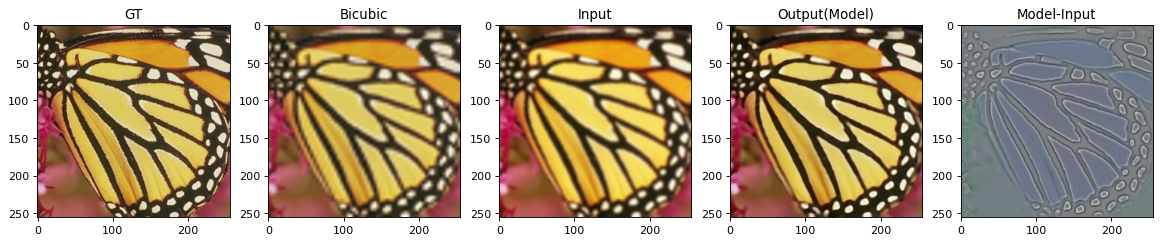

(6.354248046875, 29.39093585572352, 97.89891300513409)

In [36]:
display_PSNR(im_gt, im_b, im_b2, model, channels=1)


In [37]:
from jupyterplot import ProgressPlot


In [38]:
im_gt = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/baby_GT.bmp").convert("RGB")
im_b = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/baby_GT_scale_4.bmp").convert("RGB")
im_gt2 = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/head_GT.bmp").convert("RGB")
im_b2 = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/head_GT_scale_4.bmp").convert("RGB")

In [57]:
pp = ProgressPlot(x_iterator=False,
                  x_label="k_act",
                  x_lim=[2, 16],
                  y_lim=[[0, 16],[28,35.0],[0,30]],
                  plot_names=["kernel",'PSNR','blurryness'],
                  line_names=["pred1","pred2"])
k_act = []
k_pred = []
for k in range(2,16):
    
    kp1, err1, sharpness1 = display_PSNR(im_gt, im_b, pil_disk_blur(im_gt,k), model, channels=1, display = False)
    kp2, err2, sharpness2 = display_PSNR(im_gt2, im_b2, pil_disk_blur(im_gt2,k), model, channels=1, display = False)
    #k_act.append(k)
    #k_pred.append(display_PSNR(im_gt, im_b, pil_disk_blur(im_gt,k), model, channels=1, display = False))
    pp.update(k,[[kp1,kp2],[err1,err2],[100/sharpness1,100/sharpness2]])
    print(k, kp1, err1,100/sharpness1)
pp.finalize()    

2 3.216552734375 29.64884906939785 1.829382046125478
3 4.2437744140625 29.514401375484294 3.1138980534602365
4 4.893310546875 29.40044059643601 4.684576228915555
5 5.38720703125 29.328613210191314 7.463293757269293
6 6.022216796875 29.277726892629914 10.42101741127799
7 6.636474609375 29.248636738326724 13.129422461086673
8 7.723876953125 29.203795453485668 17.06806834427636
9 8.90673828125 29.138313987046356 22.78752346640277
10 9.4462890625 29.087407421836993 26.05328869885797
11 10.64990234375 29.031465652554797 29.77657346248509
12 12.47607421875 28.9733648933821 32.70537145935497
13 14.16943359375 28.885384552013 36.394029419657784
14 14.7255859375 28.851488586397508 37.931579124810796
15 15.38134765625 28.77947554479739 40.739687989075314


psnr for bicubic is 32.650890491818615dB
psnr for input is 32.17681713209845dB
psnr for Model is 29.09960140117365dB
PSNR improvement is -3.0772157309247987dB
Sharpness Measurement GroundTruth: 247.28295878820063
Sharpness Measurement Bicubic: 5.830031928082462
Sharpness Measurement Input: 3.8382870260975324
Sharpness Measurement Model: 22.94754407797882
Estimate of kernel: 9.4462890625


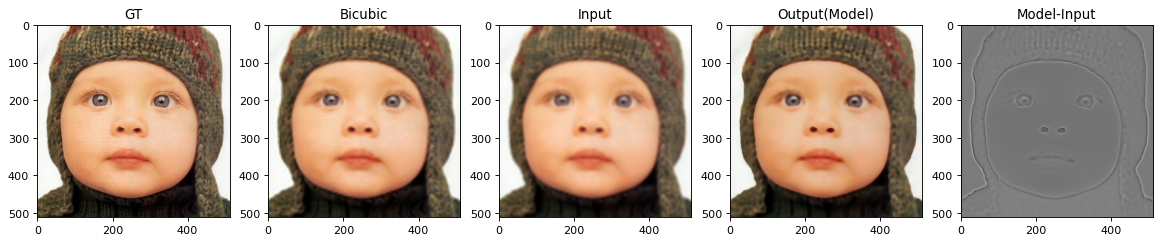

psnr for bicubic is 31.549981423720233dB
psnr for input is 30.767495650176325dB
psnr for Model is 30.34272401904559dB
PSNR improvement is -0.424771631130735dB
Sharpness Measurement GroundTruth: 726.1960912189749
Sharpness Measurement Bicubic: 12.662753095456495
Sharpness Measurement Input: 8.38781897880527
Sharpness Measurement Model: 91.62664194715167
Estimate of kernel: 9.595703125


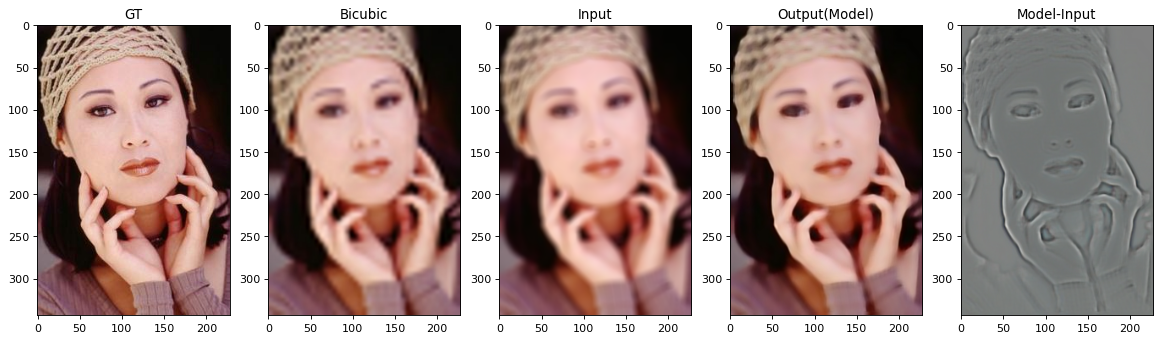

psnr for bicubic is 29.737052218222605dB
psnr for input is 28.28187662428476dB
psnr for Model is 28.816795331004137dB
PSNR improvement is 0.5349187067193775dB
Sharpness Measurement GroundTruth: 2236.2222292274237
Sharpness Measurement Bicubic: 37.85383413149975
Sharpness Measurement Input: 29.25085386261344
Sharpness Measurement Model: 238.0619225667324
Estimate of kernel: 8.93994140625


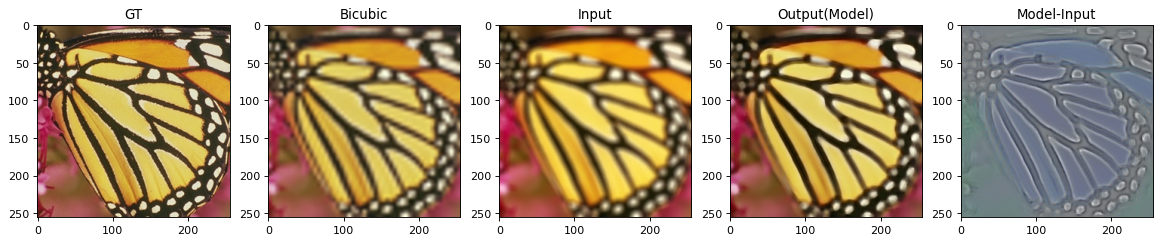

psnr for bicubic is 31.451117691239556dB
psnr for input is 30.930463203135314dB
psnr for Model is 30.37825829178457dB
PSNR improvement is -0.5522049113507457dB
Sharpness Measurement GroundTruth: 593.2631865654935
Sharpness Measurement Bicubic: 3.717168220923573
Sharpness Measurement Input: 3.588571349828197
Sharpness Measurement Model: 8.95039361447704
Estimate of kernel: 11.79541015625


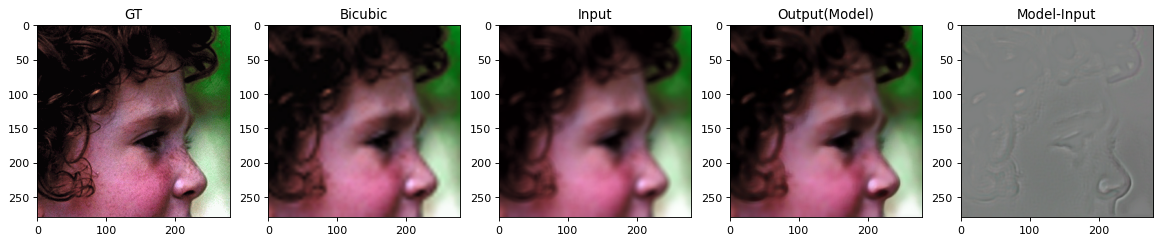

psnr for bicubic is 31.65253729172023dB
psnr for input is 30.69663159011948dB
psnr for Model is 31.582483708249065dB
PSNR improvement is 0.8858521181295842dB
Sharpness Measurement GroundTruth: 233.21159694144288
Sharpness Measurement Bicubic: 9.125577950183256
Sharpness Measurement Input: 5.750526178212013
Sharpness Measurement Model: 28.197204766450106
Estimate of kernel: 9.76171875


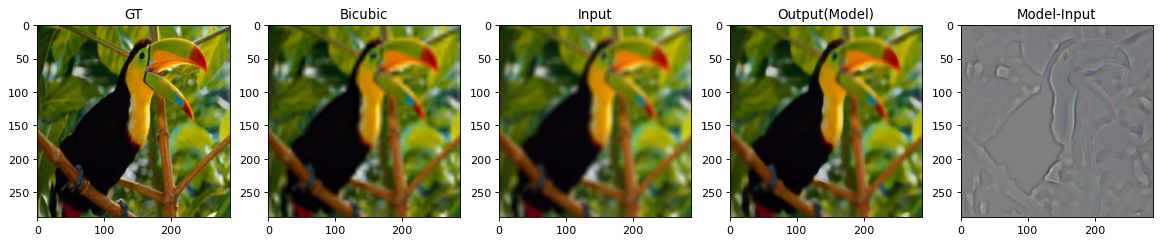

Bicubic average PSNR = 30.043972550251404
Model average PSNR = 10.163211479111292


In [60]:
test_results("/media/SSD/superres/video_data/test_data/Set5", 5, model, channels = 1,display = True)

# convert sample videos

In [41]:
result_path

PosixPath('/media/SSD/superres/Results/Superresolution train New Network upscale PRelu L1 Div2 camspec training')

In [42]:


infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-16.mp4"
superres_mp4(infile, outfile, model,channels=1, factor=1.6,display=False,bitrate= "4000k")

  1%|          | 5/900 [00:00<00:18, 49.29it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train New Network upscale PRelu L1 Div2 camspec training/muffins30sec-16.mp4
factor: 1.6 
width= 512 
height= 384 
bitrate= 4000k


100%|██████████| 900/900 [00:19<00:00, 45.19it/s]


True

In [43]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-10.mp4"
superres_mp4(infile, outfile, model,channels=1, factor=1.0,display=False,bitrate= "4000k")

  2%|▏         | 21/900 [00:00<00:04, 207.93it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train New Network upscale PRelu L1 Div2 camspec training/muffins30sec-10.mp4
factor: 1.0 
width= 320 
height= 240 
bitrate= 4000k


100%|██████████| 900/900 [00:04<00:00, 214.14it/s]


True

In [44]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-20.mp4"
superres_mp4(infile, outfile, model,channels=1, factor=2.0,display=False,bitrate= "4000k")

  1%|          | 5/900 [00:00<00:19, 45.72it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train New Network upscale PRelu L1 Div2 camspec training/muffins30sec-20.mp4
factor: 2.0 
width= 640 
height= 480 
bitrate= 4000k


100%|██████████| 900/900 [00:30<00:00, 29.38it/s]


True

In [45]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-30.mp4"
superres_mp4(infile, outfile, model,channels=1, factor=3.0,display=False,bitrate= "4000k")


  0%|          | 3/900 [00:00<00:35, 25.00it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train New Network upscale PRelu L1 Div2 camspec training/muffins30sec-30.mp4
factor: 3.0 
width= 960 
height= 720 
bitrate= 4000k


100%|██████████| 900/900 [00:37<00:00, 23.74it/s]


True

In [46]:
dualfile= str(result_path/"muffins30sec-30dual.mp4")
infile = str(infile)
outfile = str(outfile)

In [47]:
# double scale for video x3 2 min
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -t 120 -filter_complex "[0:v] scale=iw*2:ih*2, pad=2*iw:ih [left]; [1:v] scale=iw/1.5:ih/1.5 [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [48]:
# original scale , for video x3
#!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v] scale=iw*1:ih*1, pad=2*iw:ih [left]; [1:v] scale=iw/3:ih/3 [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [49]:
infile = "/media/SSD/superres/super8/super8_best_from_mp2.mp4"
outfile = result_path/"super8.mp4"
error_file = "/media/SSD/superres/error.txt"
superres_mp4(infile, outfile, model,channels=1, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

Original File: /media/SSD/superres/super8/super8_best_from_mp2.mp4
frames= 7195 
width= 720 
height= 480 
fps= 59.94005994005994

Process File: /media/SSD/superres/Results/Superresolution train New Network upscale PRelu L1 Div2 camspec training/super8.mp4
factor: 1.0 
width= 720 
height= 480 
bitrate= 4000k


100%|██████████| 7195/7195 [02:23<00:00, 49.98it/s]


True

In [50]:

dualfile = str(result_path/"super8dual.mp4")
infile = str(infile)
outfile = str(outfile)

In [51]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [52]:
# compare this model to the last one
infile = "/media/SSD/superres/Results/Superresolution train New Network upscale PRelu L1 Div2 training/super8.mp4"
outfile = str(result_path/"super8.mp4")
dualfile= str(result_path/"super8-tolast-dual.mp4")

In [53]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [54]:
infile = "/media/SSD/superres/super8/Old 8mm Reels_1.mp4"
outfile = str(result_path/"super8long.mp4")
error_file = "/media/SSD/superres/error.txt"
superres_mp4(infile, outfile, model,channels=1, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

Original File: /media/SSD/superres/super8/Old 8mm Reels_1.mp4
frames= 121409 
width= 720 
height= 480 
fps= 59.94005994005994

Process File: /media/SSD/superres/Results/Superresolution train New Network upscale PRelu L1 Div2 camspec training/super8long.mp4
factor: 1.0 
width= 720 
height= 480 
bitrate= 4000k


100%|██████████| 121409/121409 [37:34<00:00, 53.86it/s]


True

In [55]:
dualfile= str(result_path/"super8longdual.mp4")
infile = str(infile)
outfile = str(outfile)

In [56]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su